# Food Vision

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


## Downloading and Visualizing the data

In [2]:
import tensorflow_datasets as tfds

(train_data_, test_data_), ds_info = tfds.load("food101",
                                    split=["train", "validation"],
                                    shuffle_files=True,
                                    as_supervised=True,
                                    with_info=True)

In [9]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Image shape: (384, 512, 3)
Image dtype: <dtype: 'uint8'>
Target class: 97
Class name: takoyaki


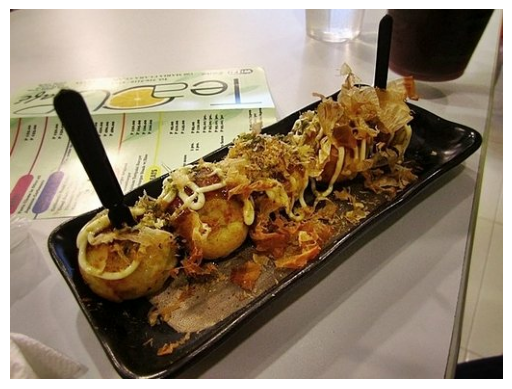

In [ ]:
import matplotlib.pyplot as plt

one_sample = train_data_.take(1)

for image, label in one_sample:
    print(f"""Image shape: {image.shape}
Image dtype: {image.dtype}
Target class: {label}
Class name: {class_names[label.numpy()]}""")

plt.imshow(image)
plt.axis(False)
plt.show()

## Preprocessing the dataset

In [5]:
def preprocess_img(image, label, img_shape=224):
    """
    Returns an image with shape (img_shape, img_shape, num_of_channels)
    and float32 dtype.
    """
    image = tf.image.resize(image, size=[img_shape, img_shape])
    return tf.cast(image, dtype=tf.float32), label

In [ ]:
train_data = train_data_.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data_.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data_.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data_.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Modelling

### Creating EfficientnetB0 feature extraction model

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

#### Creating Callbacks

In [ ]:
import os

tensorboard_dir = "drive/MyDrive/food_vision/training_logs"
checkpoint_dir = "drive/MyDrive/food_vision/checkpoints"
os.makedirs(tensorboard_dir)
os.makedirs(checkpoint_dir)

In [ ]:
import datetime

def tensorboard_callback(experiment_name):
    """
    Creates a TensorBoard callback instance to store log files.
    
    Stores log files with the filepath:
        "dir_name/experiment_name/current_datetime/"
    """
    log_dir = "drive/MyDrive/food_vision/training_logs/" + experiment_name 
    os.makedirs(log_dir)
    log_dir += "/" + datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
    
    return tensorboard_callback

def checkpoint_callback(dir_name):
    checkpoint_path = "drive/MyDrive/food_vision/checkpoints/"+ dir_name +"/"
    os.makedirs(checkpoint_path)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          monitor="val_accuracy",
                                                          save_weights_only=True,
                                                          save_best_only=True)
    return model_checkpoint

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.1,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

#### Compiling the model

In [ ]:
from tensorflow.keras import layers

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names), name="dense_layer")(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
efficientnetB0_model = tf.keras.Model(inputs, outputs)

efficientnetB0_model.compile(loss="sparse_categorical_crossentropy",
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=["accuracy"])

16719872/16705208 [==============================] - 3s 0us/step


In [ ]:
efficientnetB0_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_layer (Dense)         (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for layer in efficientnetB0_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### Fitting the model

In [ ]:
history_efficientnetB0_feature_extraction = efficientnetB0_model.fit(train_data,
                                                                     epochs=3,
                                                                     steps_per_epoch=len(train_data),
                                                                     validation_data=test_data,
                                                                     validation_steps=int(0.15 * len(test_data)),
                                                                     callbacks=[tensorboard_callback(experiment_name="efficientnetB0_feature_extraction"),
                                                                                checkpoint_callback(dir_name="efficientnetB0_feature_extraction")])

Epoch 1/3


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 244s 97ms/step - loss: 1.8202 - accuracy: 0.5558 - val_loss: 1.2312 - val_accuracy: 0.6769
Epoch 2/3
2368/2368 [==============================] - 187s 78ms/step - loss: 1.2944 - accuracy: 0.6666 - val_loss: 1.1280 - val_accuracy: 0.6978
Epoch 3/3
2368/2368 [==============================] - 186s 78ms/step - loss: 1.1443 - accuracy: 0.7012 - val_loss: 1.0865 - val_accuracy: 0.7087


In [ ]:
results_efficientnetB0_feature_extraction = efficientnetB0_model.evaluate(test_data)
results_efficientnetB0_feature_extraction

790/790 [==============================] - 53s 67ms/step - loss: 1.0912 - accuracy: 0.7068


[1.0911940336227417, 0.7068119049072266]

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

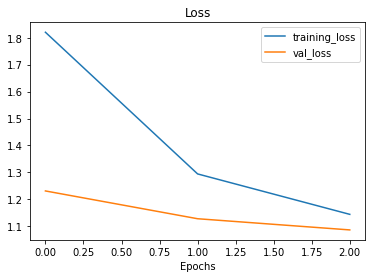

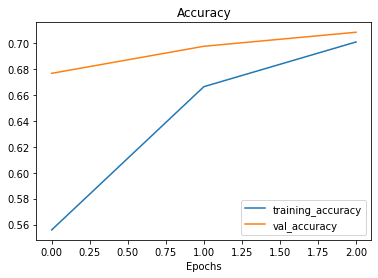

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(history_efficientnetB0_feature_extraction)

In [ ]:
save_dir = "drive/MyDrive/food_vision/saved_models/efficientnetB0_feature_extraction"
os.makedirs(save_dir)

efficientnetB0_model.save(save_dir)

In [ ]:
loaded_efficientnetB0_model = tf.keras.models.load_model(save_dir)

### Creating EfficientnetB0 fine tuning model

In [ ]:
for layer in loaded_efficientnetB0_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### Compiling the model

In [ ]:
loaded_efficientnetB0_model.compile(loss="sparse_categorical_crossentropy",
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                    metrics=["accuracy"])

#### Fitting the model

In [ ]:
history_efficientnetB0_fine_tune = loaded_efficientnetB0_model.fit(train_data,
                                                                   epochs=100,
                                                                   steps_per_epoch=len(train_data),
                                                                   validation_data=test_data,
                                                                   validation_steps=int(0.15 * len(test_data)),
                                                                   callbacks=[tensorboard_callback(experiment_name="efficientnetB0_fine_tune"),
                                                                              checkpoint_callback(dir_name="efficientnetB0_fine_tune"),
                                                                              early_stopping,
                                                                              reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 373s 151ms/step - loss: 0.9239 - accuracy: 0.7524 - val_loss: 0.8222 - val_accuracy: 0.7683 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 342s 144ms/step - loss: 0.5789 - accuracy: 0.8399 - val_loss: 0.8099 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 343s 144ms/step - loss: 0.3289 - accuracy: 0.9072 - val_loss: 0.8487 - val_accuracy: 0.7887 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9490
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2368/2368 [==============================] - 345s 145ms/step - loss: 0.1731 - accuracy: 0.9490 - val_loss: 0.9701 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 339s 142ms/step - loss: 0.0382 - accuracy: 0.9914 - val_loss: 1.0363 - val_accuracy: 0.8064 - lr: 1.0000e-05


In [ ]:
results_efficientnetB0_fine_tune = loaded_efficientnetB0_model.evaluate(test_data)
results_efficientnetB0_fine_tune

790/790 [==============================] - 60s 76ms/step - loss: 1.0318 - accuracy: 0.7990


[1.031836748123169, 0.7990494966506958]

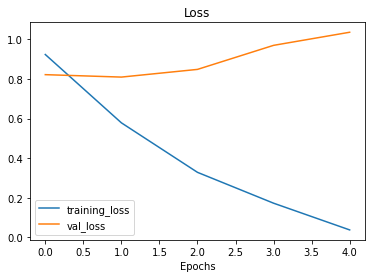

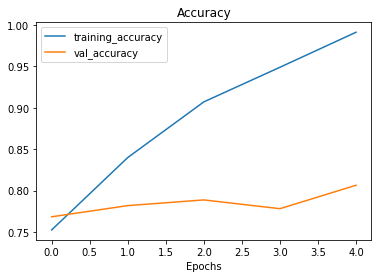

In [ ]:
plot_loss_curves(history_efficientnetB0_fine_tune)

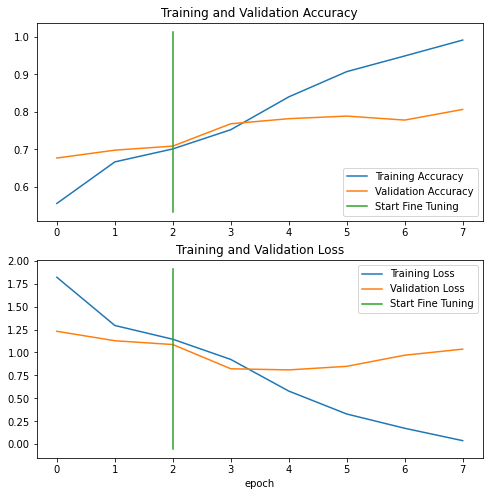

In [ ]:
from helper_functions import compare_historys
compare_historys(history_efficientnetB0_feature_extraction, history_efficientnetB0_fine_tune, initial_epochs=3)

In [ ]:
save_dir = "drive/MyDrive/food_vision/saved_models/efficientnetB0_fine_tune"
os.makedirs(save_dir)

loaded_efficientnetB0_model.save(save_dir)

### Creating EfficientnetB4 feature extraction model

#### Compiling the model

In [ ]:
from tensorflow.keras import layers

base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names), name="dense_layer")(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
efficientnetB4_model = tf.keras.Model(inputs, outputs)

efficientnetB4_model.compile(loss="sparse_categorical_crossentropy",
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=["accuracy"])

71696384/71686520 [==============================] - 6s 0us/step


In [ ]:
efficientnetB4_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense_layer (Dense)         (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-trai

In [ ]:
for layer in efficientnetB4_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### Fitting the model

In [ ]:
history_efficientnetB4_feature_extraction = efficientnetB4_model.fit(train_data,
                                                                     epochs=3,
                                                                     steps_per_epoch=len(train_data),
                                                                     validation_data=test_data,
                                                                     validation_steps=int(0.15 * len(test_data)),
                                                                     callbacks=[tensorboard_callback(experiment_name="efficientnetB4_feature_extraction"),
                                                                                checkpoint_callback(dir_name="efficientnetB4_feature_extraction")])

Epoch 1/3
2368/2368 [==============================] - 287s 116ms/step - loss: 1.8698 - accuracy: 0.5366 - val_loss: 1.3463 - val_accuracy: 0.6472
Epoch 2/3
2368/2368 [==============================] - 274s 115ms/step - loss: 1.3880 - accuracy: 0.6394 - val_loss: 1.2268 - val_accuracy: 0.6753
Epoch 3/3
2368/2368 [==============================] - 273s 115ms/step - loss: 1.2387 - accuracy: 0.6758 - val_loss: 1.1959 - val_accuracy: 0.6835


In [ ]:
results_efficientnetB4_feature_extraction = efficientnetB4_model.evaluate(test_data)
results_efficientnetB4_feature_extraction

790/790 [==============================] - 76s 96ms/step - loss: 1.1964 - accuracy: 0.6810


[1.1963615417480469, 0.6810296773910522]

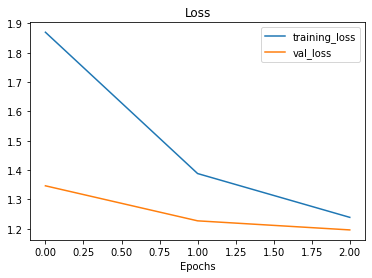

In [ ]:
plot_loss_curves(history_efficientnetB4_feature_extraction)

In [ ]:
save_dir = "drive/MyDrive/food_vision/saved_models/efficientnetB4_feature_extraction"

loaded_efficientnetB4_model = tf.keras.models.load_model(save_dir)
results_efficientnetB4_feature_extraction = loaded_efficientnetB4_model.evaluate(test_data)

790/790 [==============================] - 92s 107ms/step - loss: 1.1964 - accuracy: 0.6811


In [ ]:
loaded_efficientnetB4_model = tf.keras.models.load_model(save_dir)

### Creating EfficientnetB4 fine tuning model

In [ ]:
for layer in loaded_efficientnetB4_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### Compiling the model

In [ ]:
loaded_efficientnetB4_model.compile(loss="sparse_categorical_crossentropy",
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                    metrics=["accuracy"])

#### Fitting the model

In [ ]:
history_efficientnetB4_fine_tune = loaded_efficientnetB4_model.fit(train_data,
                                                                   epochs=100,
                                                                   steps_per_epoch=len(train_data),
                                                                   validation_data=test_data,
                                                                   validation_steps=int(0.15 * len(test_data)),
                                                                   callbacks=[tensorboard_callback(experiment_name="efficientnetB4_fine_tune"),
                                                                              checkpoint_callback(dir_name="efficientnetB4_fine_tune"),
                                                                              early_stopping,
                                                                              reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 760s 309ms/step - loss: 0.9245 - accuracy: 0.7513 - val_loss: 0.6768 - val_accuracy: 0.8106 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 730s 307ms/step - loss: 0.3916 - accuracy: 0.8885 - val_loss: 0.7023 - val_accuracy: 0.8197 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9575
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2368/2368 [==============================] - 736s 310ms/step - loss: 0.1399 - accuracy: 0.9575 - val_loss: 0.8389 - val_accuracy: 0.8056 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 727s 306ms/step - loss: 0.0250 - accuracy: 0.9939 - val_loss: 0.8643 - val_accuracy: 0.8329 - lr: 1.0000e-05


In [ ]:
results_efficientnetB4_fine_tune = loaded_efficientnetB4_model.evaluate(test_data)
results_efficientnetB4_fine_tune

790/790 [==============================] - 77s 98ms/step - loss: 0.8637 - accuracy: 0.8252


[0.8637298345565796, 0.8252277374267578]

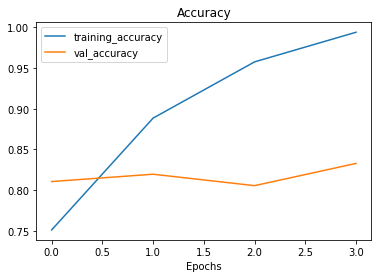

In [ ]:
plot_loss_curves(history_efficientnetB4_fine_tune)

In [ ]:
compare_historys(history_efficientnetB4_feature_extraction, history_efficientnetB4_fine_tune, initial_epochs=3)

In [ ]:
save_dir = "drive/MyDrive/food_vision/saved_models/efficientnetB4_fine_tune"
os.makedirs(save_dir)

loaded_efficientnetB4_model.save(save_dir)

### Creating EfficientnetB7 feature extraction model

#### Compiling the model

In [ ]:
from tensorflow.keras import layers

base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names), name="dense_layer")(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
efficientnetB7_model = tf.keras.Model(inputs, outputs)

efficientnetB7_model.compile(loss="sparse_categorical_crossentropy",
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=["accuracy"])

258088960/258076736 [==============================] - 17s 0us/step


In [ ]:
efficientnetB7_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 pooling_layer (GlobalAverag  (None, 2560)             0         
 ePooling2D)                                                     
                                                                 
 dense_layer (Dense)         (None, 101)               258661    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 64,356,348
Trainable params: 258,661
Non-trai

In [ ]:
for layer in efficientnetB7_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb7 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### Fitting the model

In [ ]:
history_efficientnetB7_feature_extraction = efficientnetB7_model.fit(train_data,
                                                                     epochs=3,
                                                                     steps_per_epoch=len(train_data),
                                                                     validation_data=test_data,
                                                                     validation_steps=int(0.15 * len(test_data)),
                                                                     callbacks=[tensorboard_callback(experiment_name="efficientnetB7_feature_extraction"),
                                                                                checkpoint_callback(dir_name="efficientnetB7_feature_extraction")])

Epoch 1/3
2368/2368 [==============================] - 561s 227ms/step - loss: 1.8826 - accuracy: 0.5313 - val_loss: 1.3376 - val_accuracy: 0.6488
Epoch 2/3
2368/2368 [==============================] - 534s 224ms/step - loss: 1.4052 - accuracy: 0.6349 - val_loss: 1.2523 - val_accuracy: 0.6642
Epoch 3/3
2368/2368 [==============================] - 516s 217ms/step - loss: 1.2459 - accuracy: 0.6743 - val_loss: 1.1988 - val_accuracy: 0.6817


In [ ]:
results_efficientnetB7_feature_extraction = efficientnetB7_model.evaluate(test_data)
results_efficientnetB7_feature_extraction

790/790 [==============================] - 160s 202ms/step - loss: 1.2098 - accuracy: 0.6754


[1.209790587425232, 0.6754059195518494]

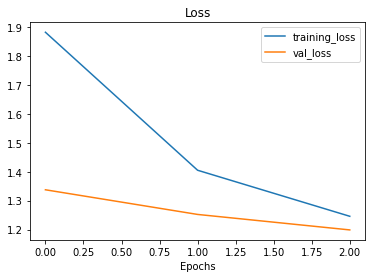

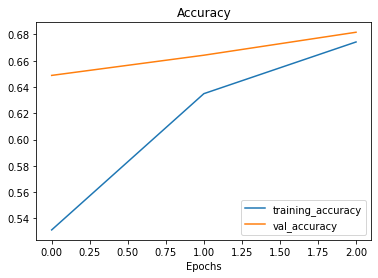

In [ ]:
plot_loss_curves(history_efficientnetB7_feature_extraction)

In [ ]:
save_dir = "drive/MyDrive/food_vision/saved_models/efficientnetB7_feature_extraction"
os.makedirs(save_dir)

efficientnetB7_model.save(save_dir)

In [ ]:
loaded_efficientnetB7_model = tf.keras.models.load_model(save_dir)

### Creating EfficientnetB7 fine tuning model

In [ ]:
for layer in loaded_efficientnetB7_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb7 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### Compiling the model

In [ ]:
loaded_efficientnetB7_model.compile(loss="sparse_categorical_crossentropy",
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                    metrics=["accuracy"])

#### Fitting the model

In [ ]:
history_efficientnetB7_fine_tune = loaded_efficientnetB7_model.fit(train_data,
                                                                   epochs=100,
                                                                   steps_per_epoch=len(train_data),
                                                                   validation_data=test_data,
                                                                   validation_steps=int(0.15 * len(test_data)),
                                                                   callbacks=[tensorboard_callback(experiment_name="efficientnetB7_fine_tune"),
                                                                              checkpoint_callback(dir_name="efficientnetB7_fine_tune"),
                                                                              early_stopping,
                                                                              reduce_lr])

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - 1594s 672ms/step - loss: 0.8790 - accuracy: 0.7628 - val_loss: 0.6314 - val_accuracy: 0.8239 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 1564s 659ms/step - loss: 0.2937 - accuracy: 0.9146 - val_loss: 0.7531 - val_accuracy: 0.8093 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9627
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2368/2368 [==============================] - 1581s 667ms/step - loss: 0.1195 - accuracy: 0.9627 - val_loss: 0.7840 - val_accuracy: 0.8114 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 1603s 676ms/step - loss: 0.0208 - accuracy: 0.9941 - val_loss: 0.7736 - val_accuracy: 0.8395 - lr: 1.0000e-05


In [ ]:
results_efficientnetB7_fine_tune = loaded_efficientnetB7_model.evaluate(test_data)
results_efficientnetB7_fine_tune

790/790 [==============================] - 166s 209ms/step - loss: 0.7725 - accuracy: 0.8417


[0.7725372314453125, 0.8416633605957031]

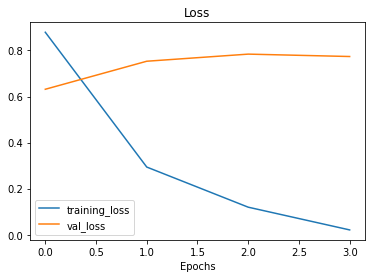

In [ ]:
from helper_functions import plot_loss_curves, compare_historys
plot_loss_curves(history_efficientnetB7_fine_tune)

In [ ]:
compare_historys(history_efficientnetB7_feature_extraction, history_efficientnetB7_fine_tune, initial_epochs=3)

In [ ]:
save_dir = "drive/MyDrive/food_vision/saved_models/efficientnetB7_fine_tune"
os.makedirs(save_dir)

loaded_efficientnetB7_model.save(save_dir)

In [ ]:
results_efficientnetB7_feature_extraction

[0.7725367546081543, 0.8416633605957031]

## Viewing Training results on Tensorboard

https://tensorboard.dev/experiment/3IOc29c8QNGGjRrmOjK9cg/

In [ ]:
!tensorboard dev upload --logdir ./drive/MyDrive/food_vision/training_logs \
   --name "EfficientNet trained on Food101" \
   --description "Training results for EfficientNetB0, EfficientNetB4, EfficientNetB7." \
   --one_shot

## Evaluating the best model EfficientNetB7

In [3]:
(train_data_eval, test_data_eval), ds_info = tfds.load("food101",
                                                split=["train", "validation"],
                                                as_supervised=True,
                                                with_info=True)

In [6]:
train_data_eval = train_data_eval.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data_eval = train_data_eval.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data_eval = test_data_eval.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data_eval = test_data_eval.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
model = tf.keras.models.load_model("saved_models/efficientnetB7_fine_tune")

In [19]:
y_true = []

for image, label in test_data_eval.unbatch():
    y_true.append(label.numpy())
    
y_true[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [20]:
y_pred = model.predict(test_data_eval, verbose=1).argmax(axis=1)
y_pred[:10]

790/790 [==============================] - 162s 190ms/step


array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

### Accuracy score

In [21]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true, y_pred)
sklearn_accuracy

0.8416633663366336

### Confusion matrix

In [22]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [23]:
make_confusion_matrix(y_true,
                      y_pred,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

### Classification report

In [24]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)

In [25]:
class_f1_scores = {}

for k, v in classification_report_dict.items():
    if k == "accuracy":
        break
    else:
        class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [26]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33           edamame  0.992000
63          macarons  0.959514
23           churros  0.947581
88     seaweed_salad  0.946535
75               pho  0.944664
..               ...       ...
0          apple_pie  0.667984
22  chocolate_mousse  0.658777
8      bread_pudding  0.649351
77         pork_chop  0.644660
93             steak  0.594828

[101 rows x 2 columns]

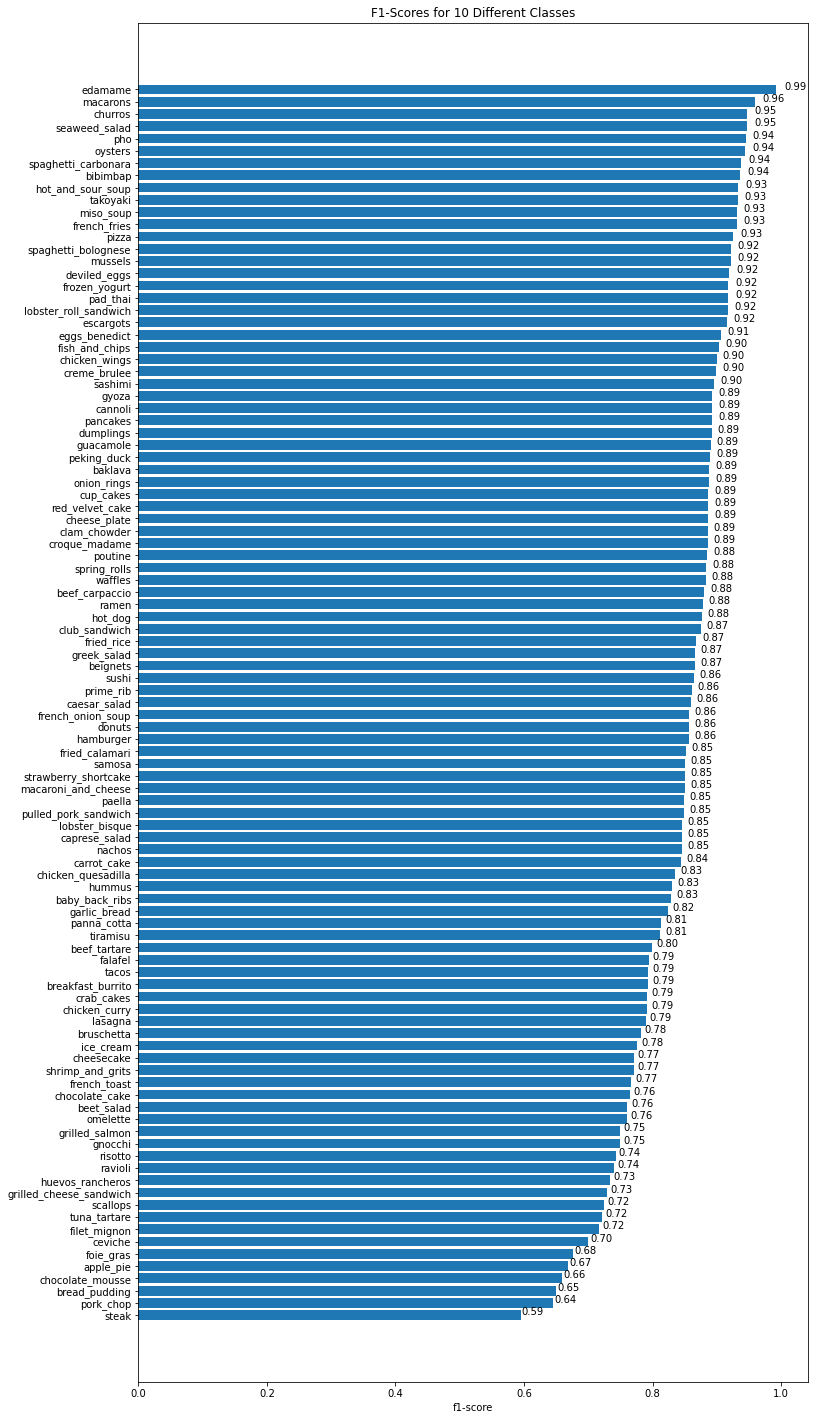

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 100 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
    """
    Attach a text label above each bar displaying its height (it's value).
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
                f"{width:.2f}",
                ha='center', va='bottom')

autolabel(scores)

### Visualizing predictions on test images

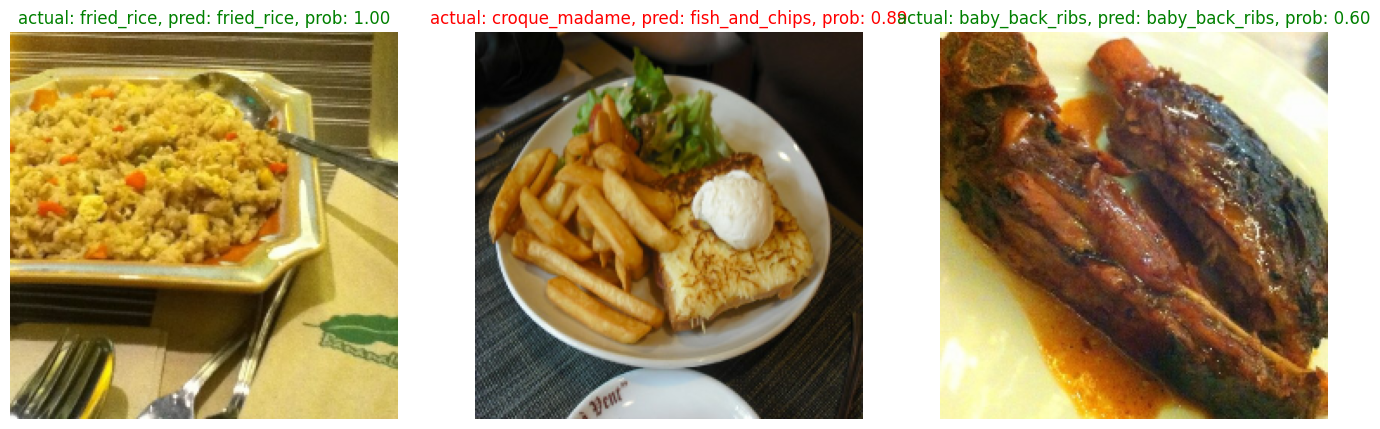

In [13]:
import random
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from a random class
    random_sample = test_data_.take(1)
    for img, label in random_sample:
        class_name = class_names[label.numpy()]

    # Load the image and make predictions
    img = tf.image.resize(img, [224, 224])
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class 

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)

### Visualizing predictions on custom data

In [15]:
custom_food_images = ["custom food images/" + img_path for img_path in os.listdir("custom food images")]
custom_food_images

['custom food images/apple_pie.jpg',
 'custom food images/lasagna.jpg',
 'custom food images/ramen.jpg',
 'custom food images/samosa.jpg',
 'custom food images/spring_rolls.jpg']

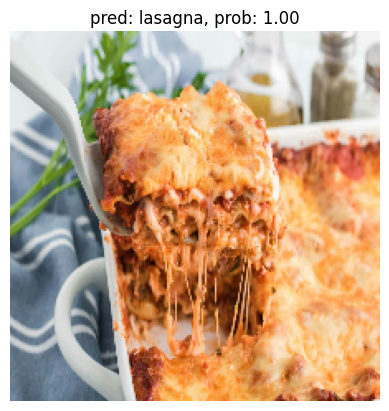

In [18]:
from helper_functions import load_and_prep_image

for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)